# 2. Data Preparation

2장에 대한 수정 작업을 develop 브랜치에서 진행하고 있음. 계속 진행하는 중. 한번 더 수정

## 2.1 Travel Demand Data (Trip record data)

수도권 생활이동 데이터 가공

In [ ]:
a = [1,2,3] 

## 2.2 Road Network and Geometry

- OSM 데이터 불러와서 OSMnx로 만져보는 실습 해보려고 해요
- 그 OSM 다운받는 방법부터 해서 그림 같은거도 같이 넣어주세요. 용량 100mb 이상 데이터는 크면 안들어가니까 그런건 좀 조심해주고

### 2.2.1 Open Street Map

OSM을 이용해서 수도권 지역의 도로 데이터를 가져오고, 시각화 하는 작업을 수행

##### Import

In [ ]:
import networkx as nx
import osmnx as ox

ox.config(use_cache=True, log_console=True)
ox.__version__

C:\Users\alstn\AppData\Local\Temp\ipykernel_7400\2418902698.py:8: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


'1.9.4'

##### 내가 원하는 지역 osm 지도를 그래프 형태로 표현

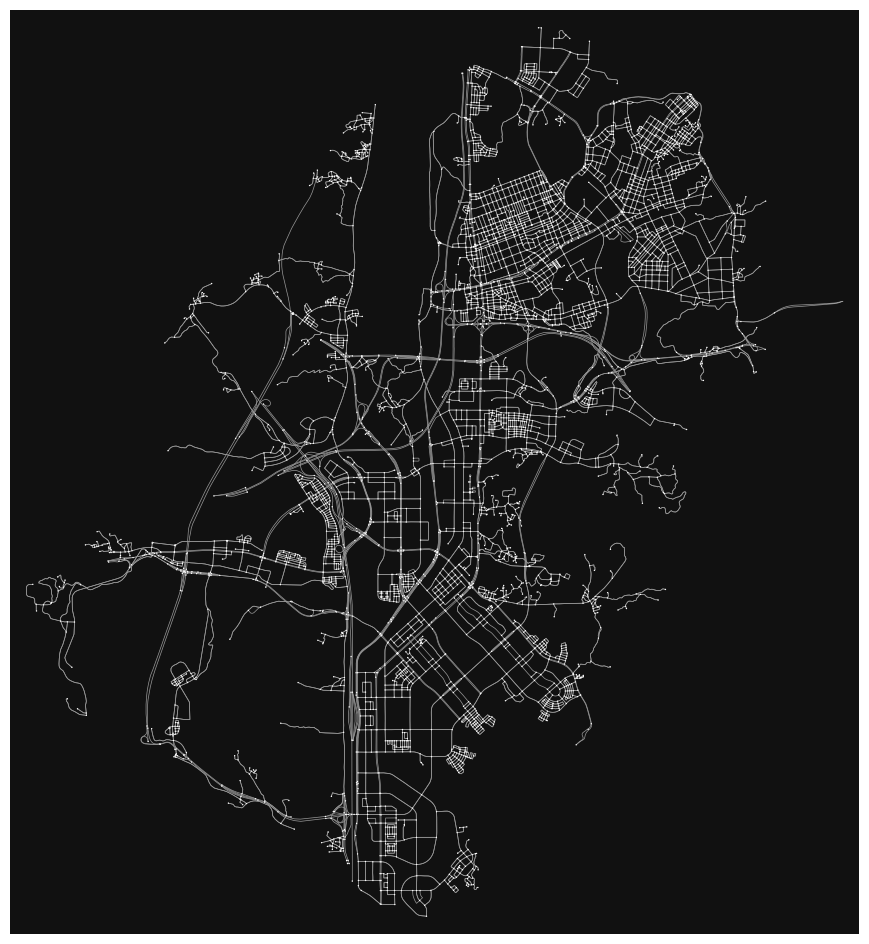

In [ ]:
# get a graph for some city
# www.openstreetmap.org에서 검색 결과가 city-state-country 단위로 나와야 함 

# # 서울특별시 전체 도로 네트워크 불러오기
# G = ox.graph_from_place('서울특별시, 대한민국', network_type='drive')

# osmnx 그래프 생성( 지도 다운로드 )
G = ox.graph_from_place('성남시, 경기도, 대한민국', network_type='drive')

## 시각화
# fig, ax = ox.plot_graph(G)
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(12, 12),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

##### 원하는 지역의 폴리곤을 활용하여 주변 반경 네트워크 시각화

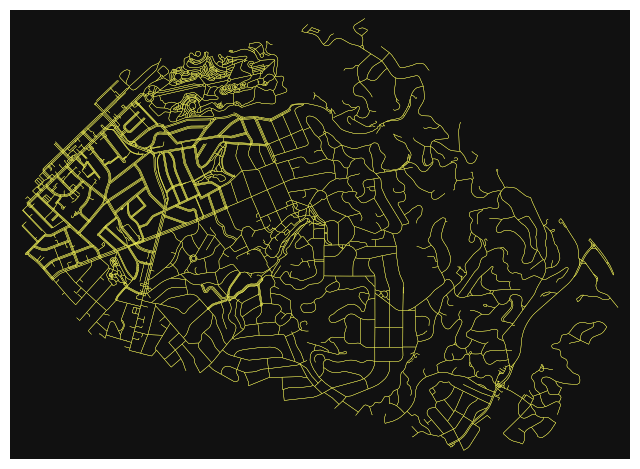

In [ ]:
# Piedmont, California 지역의 폴리곤(경계) 정보를 GeoDataFrame으로 가져옴
polygon = ox.geocode_to_gdf("Piedmont, California, USA").loc[0, "geometry"]

# 가져온 폴리곤을 적절한 투영 좌표계로 변환 (투영 좌표계를 사용하면 거리 계산이 정확해짐)
poly_proj, crs_proj = ox.projection.project_geometry(polygon)

# 투영된 폴리곤에 500미터의 버퍼를 추가하여, 해당 지역으로부터 500미터 내외의 범위 생성
# 투영 좌표계를 다시 위도/경도로 변환 (WGS84)
polygon, _ = ox.projection.project_geometry(poly_proj.buffer(500), crs=crs_proj, to_latlong=True)

# 생성된 500미터 버퍼 내에서 도보 네트워크를 가져옴
G = ox.graph_from_polygon(polygon, network_type="walk")

# 시각화
fig, ax = ox.plot_graph(
    G,                      #
    node_size=0,            # 노드 크기를 0으로 설정 (노드 표시 안함)
    edge_color="#FFFF5C",    # 엣지 색상을 노란색으로 설정
    edge_linewidth=0.25      # 엣지의 두께를 0.25로 설정
)


##### 여러 네트워크를 한번에 표시

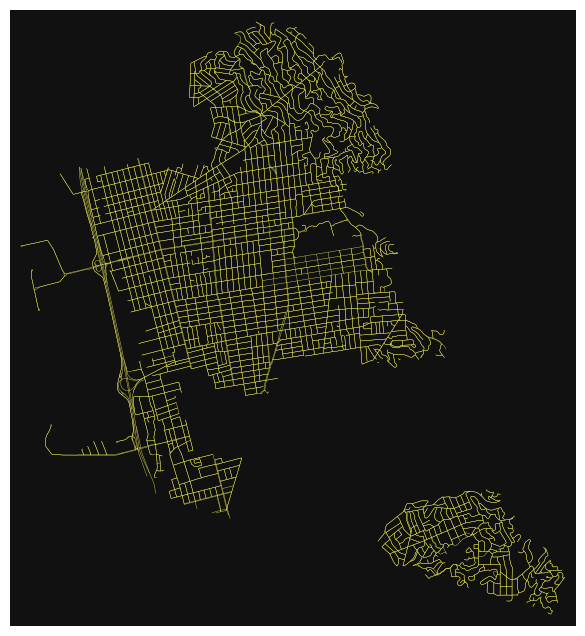

In [ ]:
# 여러 위치에서 네트워크를 생성하기 위한 장소 리스트 설정
places = [
    "Piedmont, California, USA",  
    {"city": "Berkeley", "state": "California"},  
    "Emeryville, California, USA",  
]

# retain_all=True를 사용하여 모든 연결되지 않은 서브그래프도 유지 (연속된 네트워크가 아닌 경우에도 유지)
# 여러 장소를 기반으로 차량 도로 네트워크(network_type="drive")를 생성
G = ox.graph_from_place(places, network_type="drive", retain_all=True)

# 생성된 네트워크 시각화 
fig, ax = ox.plot_graph(
    G,                      
    node_size=0,           
    edge_color="#FFFF5C",    
    edge_linewidth=0.25      
)


In [ ]:
# or create a network from structured place queries
places = [
    {"city": "Daly City", "state": "California"},
    {"city": "South San Francisco", "state": "California"},
]
G = ox.graph_from_place(places, network_type="drive")

#####  도로망 중심성 시각화

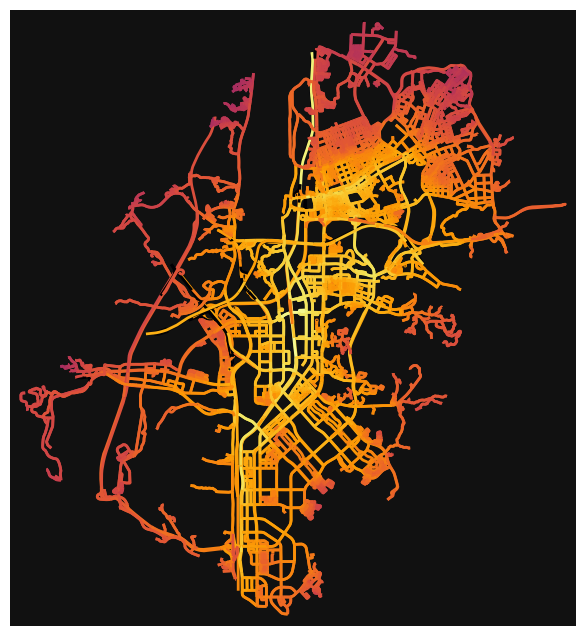

In [ ]:
# 그래프의 간선을 노드로, 노드를 간선으로 변환하여 line graph 생성
# (간선 중심성을 계산하기 위해 Line Graph 기법을 사용)
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

# 원래 그래프 G의 각 간선에 대해 closeness centrality 값을 속성으로 설정
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

# 원래 그래프의 간선을 중심성 값으로 색칠하기 위해 컬러맵(inferno)을 사용하여 색상 설정
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')

# closeness centrality 값을 바탕으로 색상이 지정된 간선을 가진 그래프 시각화
fig, ax = ox.plot_graph(
                        G,                  # 시각화할 그래프
                        edge_color=ec,      # 간선의 색상 (중심성 값에 따라 설정된 색상)
                        edge_linewidth=2,   # 간선의 두께
                        node_size=0         # 노드 크기 (0으로 설정하여 노드 미표시)
                        )

##### 최단거리 분석

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline

In [ ]:
# pip install scikit-learn
# pip install folium
# pip install scipy

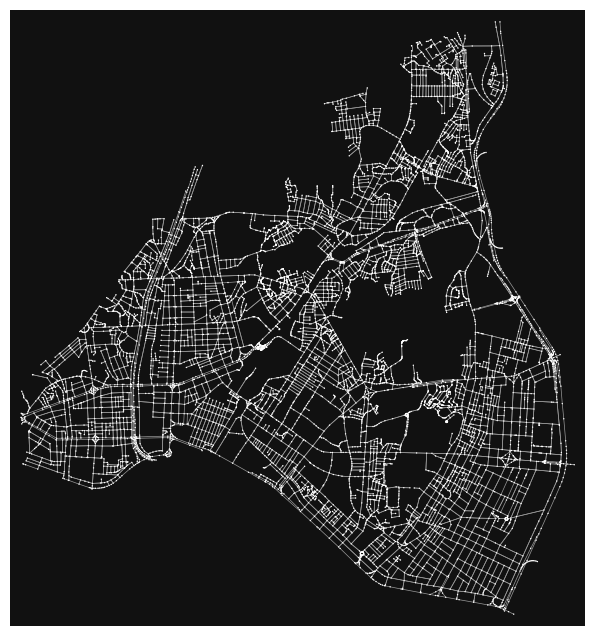

In [ ]:
# 원하는 지역 그래프 생성
G = ox.graph_from_place('동대문구, 서울, 대한민국', network_type='drive', simplify=False)

# 그래프 시각화
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(8, 8),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

In [ ]:
## 직각 좌표계로 변환
# G_proj = ox.project_graph(G)

# 출발지 도착지 좌표 설정
orig_node = ox.nearest_nodes(G, 127.0462200, 37.5804100) #청량리역
dest_node = ox.nearest_nodes(G, 127.0114887, 37.5718616) #동대문역

In [ ]:
# 최단 거리 경로 추출
route = nx.shortest_path(G, orig_node, dest_node, weight='length')

In [ ]:
# 최단 거리 추출
len = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / 1000
print(round(len, 1), "킬로미터")

2.9 킬로미터


In [ ]:
# 촤단거리 지도 생성
route_graph_map = ox.plot_route_folium(G, route, popup_attribute='length')
    
# 출발지와 목적지 좌표
orig_node_xy = (G.nodes[orig_node]['y'], G.nodes[orig_node]['x'])  # (위도, 경도)
dest_node_xy = (G.nodes[dest_node]['y'], G.nodes[dest_node]['x'])  # (위도, 경도)

# 출발지 마커 추가
folium.Marker(location=orig_node_xy, popup='출발지', icon=folium.Icon(color='green')).add_to(route_graph_map)

# 목적지 마커 추가
folium.Marker(location=dest_node_xy, popup='목적지', icon=folium.Icon(color='red')).add_to(route_graph_map)

# 지도 시각화
route_graph_map

# 지도 저장 
# filepath = 'data/route_graph.html' # 경로 지정
# route_graph_map.save(filepath)

C:\Users\alstn\AppData\Local\Temp\ipykernel_7400\861946550.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_graph_map = ox.plot_route_folium(G, route, popup_attribute='length')


##### 이동 속도 및 시간 영향

In [ ]:
# 위의 그래프의 모든 엣지에 속도를 부여
G = ox.add_edge_speeds(G)

# 모든 에지에 대한 이동 시간(초) 계산
G = ox.add_edge_travel_times(G)

In [ ]:
# 도로 유형별 평균 속도/시간 값 보기
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
living_street,22.2,44.6,1.8
primary,31.5,56.2,2.0
primary_link,12.7,30.0,1.5
residential,27.5,30.4,3.3
secondary,31.7,42.5,2.7
secondary_link,16.5,46.2,1.3
tertiary,34.6,30.7,4.1
tertiary_link,20.9,44.6,1.7
trunk,54.0,76.1,2.5


In [ ]:
# 도로 별 속도 지정
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60} # residential : 주거지도로 secondary : 지방도 tertiary: 시도·군도·구도
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)

In [ ]:
# 이동 거리와 이동 시간을 최소화한 두 가지 경로를 계산합니다

# 그래프 내에서 출발지 목적지 가져오기
orig = list(G)[1]
dest = list(G)[111]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

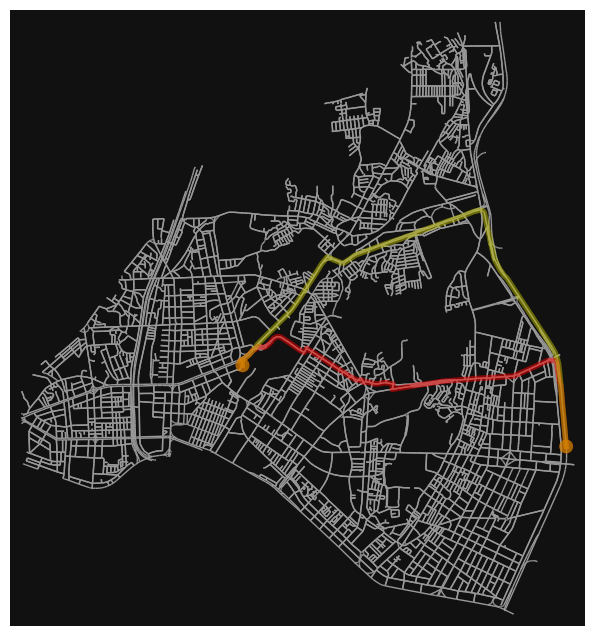

In [ ]:
# 시각화
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [ ]:
# 두 경로 비교
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 3897 meters and takes 325 seconds.
Route 2 is 4942 meters and takes 300 seconds.


## 2.3 GTFS (General Transit Feed Specification)